<a href="https://colab.research.google.com/github/spdrnl/ecg/blob/master/ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replication study of "ECG Heartbeat Classification: A Deep Transferable Representation"

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl
mpl.style.use('seaborn')

# Move data from Drive to /tmp

In [2]:
# You can obtain the data from Kaggle at https://www.kaggle.com/shayanfazeli/heartbeat
from google.colab import drive
drive.mount("/tmp/drive")
! unzip "/tmp/drive/My Drive/data/29414_37484_bundle_archive.zip" -d /tmp/ecg
! ls /tmp/ecg

Drive already mounted at /tmp/drive; to attempt to forcibly remount, call drive.mount("/tmp/drive", force_remount=True).
Archive:  /tmp/drive/My Drive/data/29414_37484_bundle_archive.zip
replace /tmp/ecg/mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
mitbih_test.csv  mitbih_train.csv  ptbdb_abnormal.csv  ptbdb_normal.csv


# Import and analyse data
## MIT-BIH Arhythmia dataset

In [3]:
mitbih_test = pd.read_csv("/tmp/ecg/mitbih_test.csv", header=None)
mitbih_train = pd.read_csv("/tmp/ecg/mitbih_train.csv", header=None)

In [4]:
mitbih_train.shape

(87554, 188)

### Explore feature and label distribution

In [5]:
mitbih_labels = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
mitbih_reverse_labels = {v:k for k,v in mitbih_labels.items()}
mitbih_train_labels = mitbih_train.iloc[:,-1].replace(mitbih_reverse_labels)

Text(0.5, 1.0, 'Distribution of labels in MIT-BIH Arhythmia dataset')

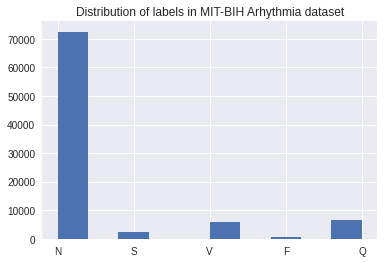

In [6]:
plt.hist(mitbih_train_labels)
plt.title("Distribution of labels in MIT-BIH Arhythmia dataset")

Text(0.5, 1.0, 'MIT-BIH Arrhythmia Dataset example signal')

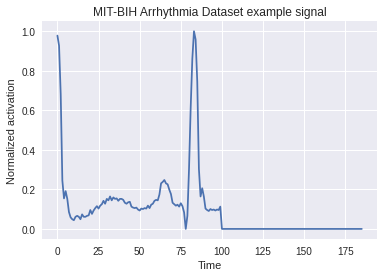

In [7]:
plt.plot(mitbih_train.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("MIT-BIH Arrhythmia Dataset example signal")

### Explore data quality

In [8]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [9]:
print("The minimum and maximum values are {}, {}".format(np.min(mitbih_train.iloc[:,:-2].values), np.max(mitbih_train.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


## PTB Diagnostic ECG Database

In [10]:
ptbdb_abnormal = pd.read_csv("/tmp/ecg/ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("/tmp/ecg/ptbdb_normal.csv", header=None)
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0, ignore_index=True)

In [11]:
ptbdb.shape

(14552, 188)

In [12]:
ptbdb_abnormal.values[:,-1] # Abnormal is labelled one as per convention

array([1., 1., 1., ..., 1., 1., 1.])

### Explore features and labels

In [13]:
ptbdb_labels = {'Normal': 0, 'Abnormal': 1}
ptbdb_reverse_labels = {v:k for k,v in ptbdb_labels.items()}
ptbdb_labels = ptbdb.iloc[:,-1].replace(ptbdb_reverse_labels)

Text(0.5, 1.0, 'Distribution of the PTB Diagnostic ECG Database labels')

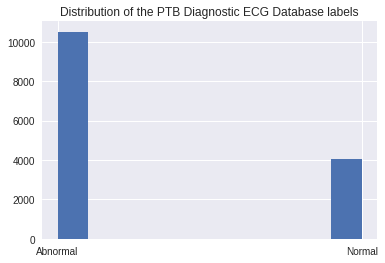

In [14]:
plt.hist(ptbdb_labels)
plt.title("Distribution of the PTB Diagnostic ECG Database labels")

### Explore data quality

In [15]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [16]:
print("The minimum and maximum values are {}, {}".format(np.min(ptbdb.iloc[:,:-2].values), np.max(ptbdb.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


Text(0.5, 1.0, 'PTB Diagnostic ECG Database example signal')

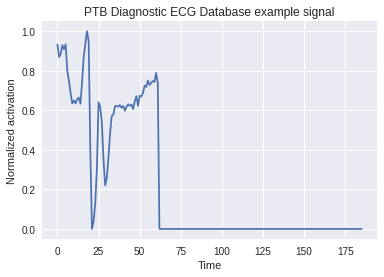

In [17]:
plt.plot(ptbdb.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("PTB Diagnostic ECG Database example signal")

# Helper functions

In [18]:
# Copied from https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py
# Apache License 2.0

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [19]:
def pretty_plot(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Baseline MLP

In [21]:
def get_base_model(categories=2):
  return keras.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=[187], kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(5, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 2 else keras.layers.Dense(5, activation='softmax'))                   
  ])

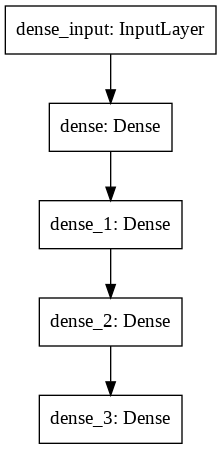

In [22]:
tf.keras.utils.plot_model(
    get_base_model(),
    to_file="model.png")

## Baseline PTB check

In [23]:
X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values, test_size=0.2, random_state=42)
X_ptbdb_val, X_ptbdb_test, y_ptbdb_val, y_ptbdb_test  = train_test_split(X_ptbdb_val, y_ptbdb_val, test_size=0.5, random_state=42)

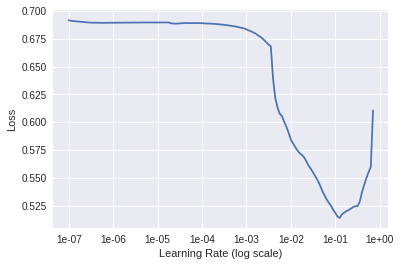

In [24]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_base_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-2, max_steps=100, smoothing=0.6)
_ = model.fit(X_ptbdb_train, y_ptbdb_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [25]:
# Set cyclical learning rate
N = X_ptbdb_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-4, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

base_model = get_base_model() 
base_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = base_model.fit(X_ptbdb_train, y_ptbdb_train, validation_data=(X_ptbdb_val, y_ptbdb_val), 
                         shuffle=True, batch_size=batch_size, epochs=150, callbacks=[save_best_weights])

Epoch 1/150
91/91 [==============================] - 1s 7ms/step - loss: 0.6303 - accuracy: 0.6225 - val_loss: 0.4872 - val_accuracy: 0.7409
Epoch 2/150
91/91 [==============================] - 0s 4ms/step - loss: 0.4400 - accuracy: 0.7614 - val_loss: 0.4220 - val_accuracy: 0.7869
Epoch 3/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3788 - accuracy: 0.8198 - val_loss: 0.3673 - val_accuracy: 0.8227
Epoch 4/150
91/91 [==============================] - 0s 5ms/step - loss: 0.3465 - accuracy: 0.8392 - val_loss: 0.3471 - val_accuracy: 0.8247
Epoch 5/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3327 - accuracy: 0.8451 - val_loss: 0.3478 - val_accuracy: 0.8337
Epoch 6/150
91/91 [==============================] - 0s 5ms/step - loss: 0.3154 - accuracy: 0.8614 - val_loss: 0.3175 - val_accuracy: 0.8653
Epoch 7/150
91/91 [==============================] - 0s 5ms/step - loss: 0.2815 - accuracy: 0.8808 - val_loss: 0.3020 - val_accuracy: 0.8701
Epoch 8/150
9

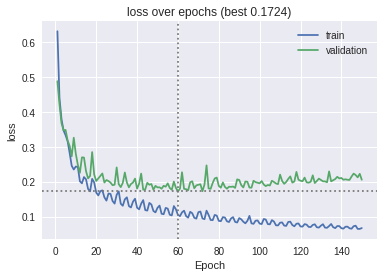

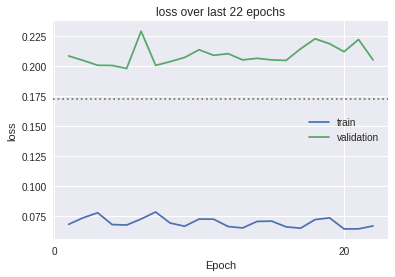

In [26]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

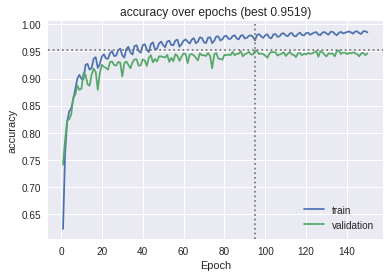

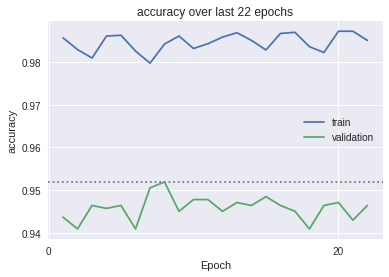

In [27]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [28]:
base_model.load_weights('weights.hdf5')
base_model.evaluate(X_ptbdb_test, y_ptbdb_test)

46/46 [==============================] - 0s 2ms/step - loss: 0.1508 - accuracy: 0.9512


[0.15083305537700653, 0.9512362480163574]

Confusion matrix, without normalization
[[ 350   35]
 [  36 1035]]


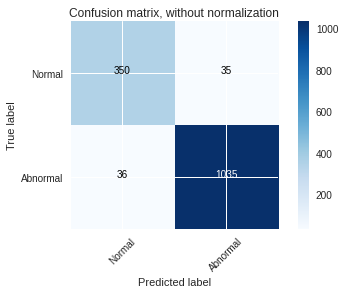

In [29]:
y_pred = (base_model.predict(X_ptbdb_test) > 0.5).astype("int32")

# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

# ResNet model

In [30]:
def get_resnet_model(categories=2):
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    return out

  kernels = 32
  stride = 5

  inputs = keras.layers.Input([187,1])
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

## ResNet PTB replication

In [31]:
X_ptbdbl_train = np.expand_dims(X_ptbdb_train, -1)
y_ptbdbl_train = np.expand_dims(y_ptbdb_train, -1)

X_ptbdbl_val = np.expand_dims(X_ptbdb_val, -1)
y_ptbdbl_val = np.expand_dims(y_ptbdb_val, -1)

X_ptbdbl_test = np.expand_dims(X_ptbdb_test, -1)
y_ptbdbl_test = np.expand_dims(y_ptbdb_test, -1)

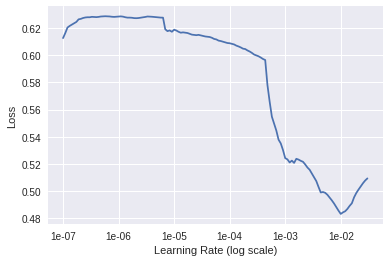

In [32]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-03, max_steps=100, smoothing=0.6)
_ = model.fit(X_ptbdbl_train, y_ptbdbl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [33]:
# Set cyclical learning rate
N = X_ptbdbl_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

resnet_model = get_resnet_model() 
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), 
                           shuffle=True, batch_size=batch_size, epochs=75, callbacks=[save_best_weights])

Epoch 1/75
91/91 [==============================] - 2s 21ms/step - loss: 0.5765 - accuracy: 0.6672 - val_loss: 0.4034 - val_accuracy: 0.8323
Epoch 2/75
91/91 [==============================] - 1s 14ms/step - loss: 0.3504 - accuracy: 0.8463 - val_loss: 0.2572 - val_accuracy: 0.9052
Epoch 3/75
91/91 [==============================] - 1s 15ms/step - loss: 0.2114 - accuracy: 0.9216 - val_loss: 0.2407 - val_accuracy: 0.8942
Epoch 4/75
91/91 [==============================] - 1s 15ms/step - loss: 0.1433 - accuracy: 0.9490 - val_loss: 0.1178 - val_accuracy: 0.9663
Epoch 5/75
91/91 [==============================] - 1s 14ms/step - loss: 0.1233 - accuracy: 0.9555 - val_loss: 0.1024 - val_accuracy: 0.9677
Epoch 6/75
91/91 [==============================] - 1s 15ms/step - loss: 0.1217 - accuracy: 0.9566 - val_loss: 0.0961 - val_accuracy: 0.9684
Epoch 7/75
91/91 [==============================] - 1s 14ms/step - loss: 0.0805 - accuracy: 0.9728 - val_loss: 0.0819 - val_accuracy: 0.9649
Epoch 8/75
91

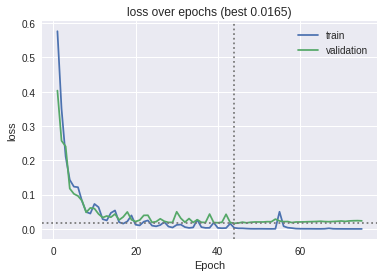

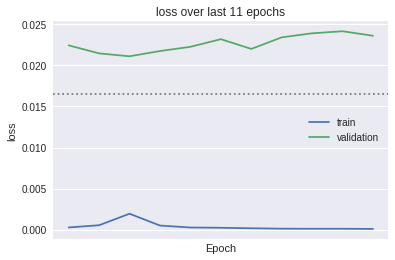

In [34]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

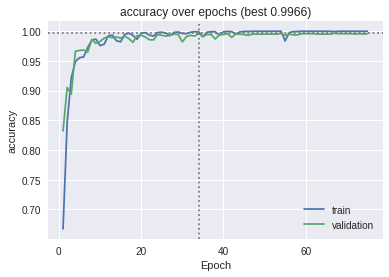

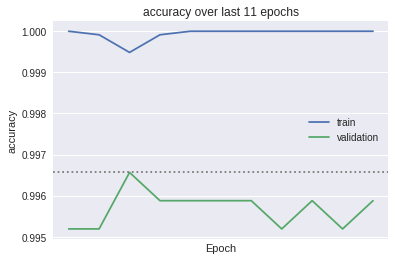

In [35]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [36]:
resnet_model.load_weights('weights.hdf5')
resnet_model.evaluate(X_ptbdbl_test, y_ptbdbl_test)

46/46 [==============================] - 0s 5ms/step - loss: 0.0095 - accuracy: 0.9973


[0.009494303725659847, 0.9972527623176575]

Confusion matrix, without normalization
[[ 384    1]
 [   3 1068]]


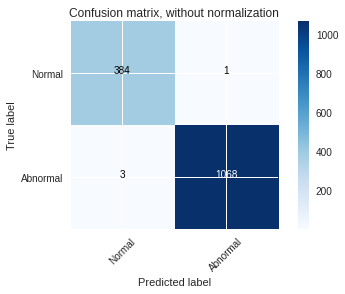

In [37]:
y_pred = (resnet_model.predict(X_ptbdbl_test) > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

## ResNet MIH replication

In [38]:
X_mitbih_train, X_mitbih_val, y_mitbih_train, y_mitbih_val = train_test_split(mitbih_train.iloc[:,:-1].values, mitbih_train.iloc[:,-1].values, test_size=0.1, random_state=42)
X_mitbih_test = mitbih_test.iloc[:,:-1].values
y_mitbih_test = mitbih_test.iloc[:,-1].values

# The 1D convolutions expect an extra dimension in the input data 
X_mitbihl_train = np.expand_dims(X_mitbih_train, -1)
y_mitbihl_train = np.expand_dims(y_mitbih_train, -1)
X_mitbihl_val = np.expand_dims(X_mitbih_val, -1)
y_mitbihl_val = np.expand_dims(y_mitbih_val, -1)
X_mitbihl_test = np.expand_dims(X_mitbih_test, -1)
y_mitbihl_test = np.expand_dims(y_mitbih_test, -1)

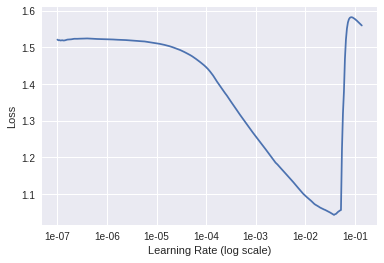

In [39]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model(5) 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-06, max_steps=50, smoothing=0.6)
_ = model.fit(X_mitbihl_train, y_mitbihl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [40]:
lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_resnet_model = get_resnet_model(5)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = m_resnet_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=50, callbacks=[save_best_weights])

Epoch 1/50
616/616 [==============================] - 9s 15ms/step - loss: 0.3522 - accuracy: 0.8910 - val_loss: 0.1708 - val_accuracy: 0.9512
Epoch 2/50
616/616 [==============================] - 8s 13ms/step - loss: 0.1399 - accuracy: 0.9622 - val_loss: 0.1261 - val_accuracy: 0.9644
Epoch 3/50
616/616 [==============================] - 8s 13ms/step - loss: 0.1107 - accuracy: 0.9703 - val_loss: 0.0960 - val_accuracy: 0.9744
Epoch 4/50
616/616 [==============================] - 8s 13ms/step - loss: 0.0957 - accuracy: 0.9741 - val_loss: 0.0948 - val_accuracy: 0.9737
Epoch 5/50
616/616 [==============================] - 8s 14ms/step - loss: 0.0813 - accuracy: 0.9776 - val_loss: 0.0885 - val_accuracy: 0.9758
Epoch 6/50
616/616 [==============================] - 8s 13ms/step - loss: 0.0746 - accuracy: 0.9792 - val_loss: 0.0761 - val_accuracy: 0.9785
Epoch 7/50
616/616 [==============================] - 8s 13ms/step - loss: 0.0675 - accuracy: 0.9805 - val_loss: 0.0711 - val_accuracy: 0.9793

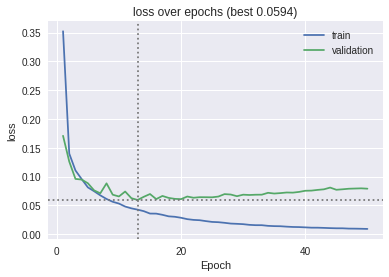

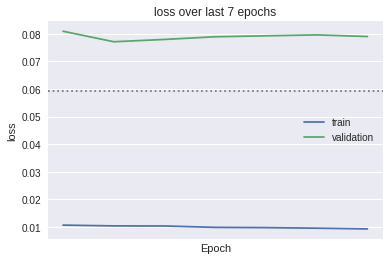

In [41]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

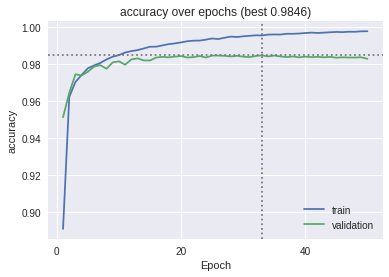

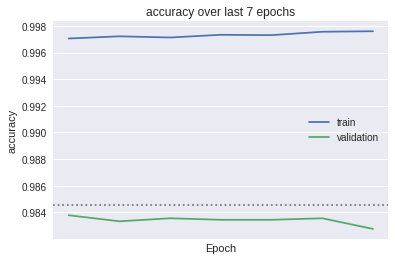

In [42]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [43]:
m_resnet_model.load_weights('weights.hdf5')
X_mitbih_test = m_resnet_model.evaluate(X_mitbihl_test, y_mitbihl_test)

685/685 [==============================] - 3s 4ms/step - loss: 0.0607 - accuracy: 0.9845


Confusion matrix, without normalization
[[18063    23    18     4    10]
 [  124   417    13     1     1]
 [   52     3  1374    15     4]
 [   30     0    16   116     0]
 [   23     2     0     0  1583]]


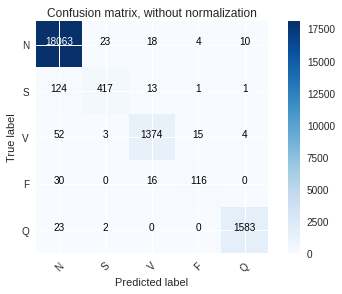

In [44]:
y_pred = tf.argmax(m_resnet_model.predict(X_mitbihl_test), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')

# Transfer learning application

In [45]:
m_resnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 183, 32)      192         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 183, 32)      5152        conv1d_33[0][0]                  
__________________________________________________________________________________________________
re_lu_30 (ReLU)                 (None, 183, 32)      0           conv1d_34[0][0]                  
____________________________________________________________________________________________

In [46]:
# Reuse the MIT trained model, except the last three layers
def get_transfer_model(model):
  model.trainable = False
  model_input = model.inputs
  model_output = model.layers[-4].output

  X = keras.layers.Dense(32, activation='relu')(model_output)
  X = keras.layers.Dense(32, activation='relu')(X)
  out = keras.layers.Dense(1, activation='sigmoid')(X)

  transfer_model = keras.Model(inputs=model_input, outputs=out)
  return transfer_model

get_transfer_model(m_resnet_model).summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 183, 32)      192         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 183, 32)      5152        conv1d_33[0][0]                  
__________________________________________________________________________________________________
re_lu_30 (ReLU)                 (None, 183, 32)      0           conv1d_34[0][0]                  
____________________________________________________________________________________________

In [53]:
optimizer = keras.optimizers.Adam(lr=0.001)
transfer_model = get_transfer_model(m_resnet_model)

save_best_weights = ModelCheckpoint(filepath="tweights.hdf5", verbose=0, save_best_only=True)

transfer_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = transfer_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), 
                             shuffle=True, batch_size=128, epochs=100, callbacks=[save_best_weights])

Epoch 1/100
91/91 [==============================] - 1s 12ms/step - loss: 0.4261 - accuracy: 0.8102 - val_loss: 0.3530 - val_accuracy: 0.8488
Epoch 2/100
91/91 [==============================] - 1s 9ms/step - loss: 0.3144 - accuracy: 0.8641 - val_loss: 0.2925 - val_accuracy: 0.8674
Epoch 3/100
91/91 [==============================] - 1s 9ms/step - loss: 0.2769 - accuracy: 0.8808 - val_loss: 0.2907 - val_accuracy: 0.8701
Epoch 4/100
91/91 [==============================] - 1s 9ms/step - loss: 0.2595 - accuracy: 0.8887 - val_loss: 0.2525 - val_accuracy: 0.8935
Epoch 5/100
91/91 [==============================] - 1s 9ms/step - loss: 0.2440 - accuracy: 0.8967 - val_loss: 0.2406 - val_accuracy: 0.9003
Epoch 6/100
91/91 [==============================] - 1s 8ms/step - loss: 0.2247 - accuracy: 0.9075 - val_loss: 0.2631 - val_accuracy: 0.8818
Epoch 7/100
91/91 [==============================] - 1s 9ms/step - loss: 0.2088 - accuracy: 0.9143 - val_loss: 0.2172 - val_accuracy: 0.9079
Epoch 8/100


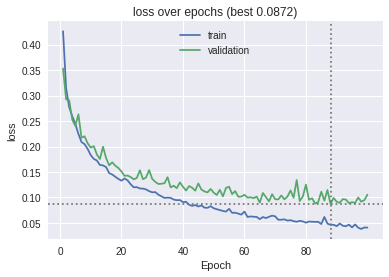

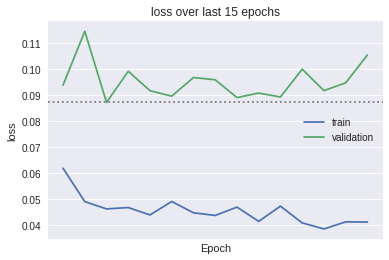

In [54]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

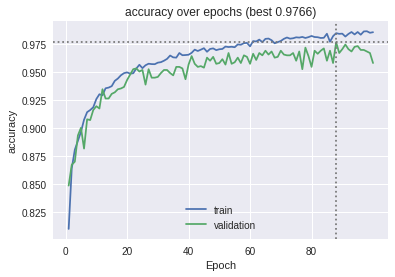

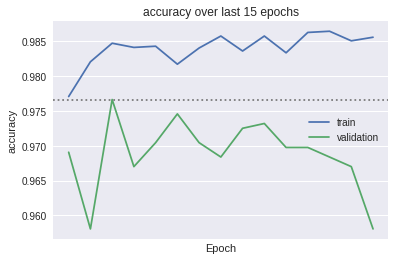

In [55]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [56]:
transfer_model.load_weights('tweights.hdf5')
transfer_model.evaluate(X_ptbdbl_test, y_ptbdb_test)

46/46 [==============================] - 0s 5ms/step - loss: 0.1090 - accuracy: 0.9643


[0.10902048647403717, 0.9642857313156128]

Confusion matrix, without normalization
[[ 360   25]
 [  27 1044]]


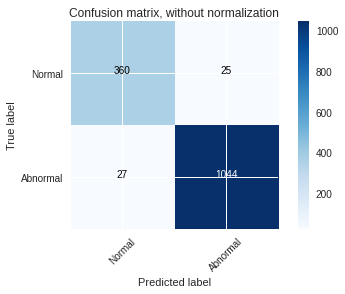

In [57]:
y_pred = (transfer_model.predict(X_ptbdbl_test) >= 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')